<h2><center>Predicting Home Values in Los Angeles’ South Bay</center></h2>
<h3><center>Springboard | Capstone #1 - In Depth Analysis</center></h3>
<h4><center>By: Lauren Broussard</center></h4>

[DRAFT]
---

Using our previous findings, we will use supervised machine learning regression methods to determine the best model to predict housing prices in this area. We will then compare the performance of each of these models, to determine which method performs the best. Additionally, we will determine which features are truly important in predicting home prices in this area. 

As we are looking at a continuous random variable (and not a discrete, classification problem), we will be looking at the following regression machine learning methods: 

- **Linear Regression** 
- **Ridge Regression**
- **Random Forest Regression**

* train/test split
* fit data
* predict data
* get model performance information 

* tuning hyperparameters
* feature selection

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://towardsdatascience.com/machine-learning-simple-linear-regression-with-python-f04ecfdadc13

https://github.com/sherpalakpa1/PredictHousePrice/blob/master/PredictHousePriceApproach1.ipynb


In [1]:
# import relevant libraries
import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset 
south_bay = pd.read_csv('south_bay_cleaned.csv', parse_dates=['SOLD DATE'])
south_bay['ZIP OR POSTAL CODE'] = south_bay['ZIP OR POSTAL CODE'].astype(str)

In [3]:
# split data into target and features 
X = south_bay.drop(['PRICE','SOLD DATE','PROPERTY TYPE','ADDRESS','CITY','MLS#','NEIGHBORHOOD'],axis=1) 
# also drop features of type "Object"
y = south_bay['PRICE']

In [4]:
# split data into training and testing 
from sklearn.model_selection import train_test_split 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

## Linear Regression

We'll start with a basic Linear Regression. 

In [5]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression() # create Regression object 
fit = reg.fit(X_train,y_train) # fit training data 
pred = reg.predict(X_test)

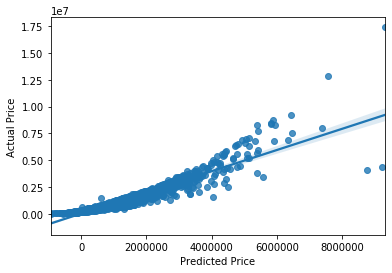

In [13]:
# visualize predicted data vs test data 

_ = sns.regplot(pred,y_test)
_ = plt.xlabel('Predicted Price')
_ = plt.ylabel('Actual Price')

Our predicted prices seem to fit fairly well with our actual prices, however, there appears to be a number of outliers in the model. 

In [18]:
#Compute accuracy on the training set
train_accuracy = reg.score(X_train, y_train)

#Compute accuracy on the testing set
test_accuracy = reg.score(X_test, y_test)

print("Training Accuracy: {d}".format(d=train_accuracy))

print("Testing Accuracy: {d}".format(d=test_accuracy))

Training Accuracy: 0.875632422210083
Testing Accuracy: 0.8820437382380477


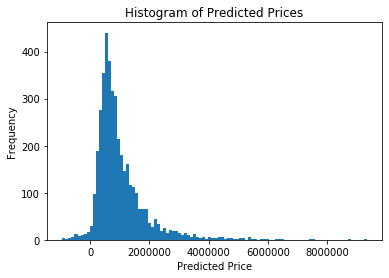

### Feature Selection

## Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_train,y_train)
ridge.predict(X_test)

ridge.score(X_test,y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.1876e-18): result may not be accurate.
  overwrite_a=True).T


0.8820598202524186

In [ ]:
# TODO: Tune hyperparameters for ridge regression

## Random Forest Regression

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

# Train the model on training data
rf.fit(X_test, y_test)
rf.predict(X_test)
rf.score(X_test,y_test)

0.9875533705420698

In [ ]:
# TODO: Tune hyperparameters for random forest regression

## Performance Comparisons

In [ ]:
# TODO: Visualize score for Ridge, Linear Regression, and Random Forest Regression 

# create a bar graph of model performance for each of the models 




## Conclusion